In [1]:
from KRI import Dataset
import pandas as pd
import lightgbm as lgb
import numpy as np
from util import sfl_defaults
import matplotlib.pyplot as plt

sfl_defaults()

c10 = Dataset(path='../../Data/c10/')
c11 = Dataset(path='../../Data/c11/')
c12 = Dataset(path='../../Data/c12/')
c13 = Dataset(path='../../Data/c13/')
c15 = Dataset(path='../../Data/c15/')

dfs= [c10, c11, c12, c13, c15]

In [2]:
for df in dfs:
    last_day = int(df._site_active.EndDay.max())
    print(last_day)
    df.score_all(0, last_day, 25)

1568
143
767
6617
365


In [3]:
out = []
for df in dfs:
    df_out = []
    print(df)
    for site in df._site_list:
        temp = []
        for KRI_df_name in ['Safety', "Data_Quality", "IP_Management", "SB_Management", "LB_Management"]:
            KRI_df = getattr(df, KRI_df_name)
            if not KRI_df.empty:
                for KRI_type in KRI_df.KRI_Type.unique():
                    temp.append(KRI_df[(KRI_df.KRI_Type == KRI_type) & (KRI_df.Site == site)][['Start_Time', 'Value']].rename({'Value': KRI_type}, axis=1))


        site_table = pd.DataFrame()

        for temp_df in temp:
            if site_table.empty:
                site_table = temp_df
            else:
                site_table = site_table.merge(temp_df, on = 'Start_Time')

        site_table = site_table.interpolate()

        site_table['Site'] = site
        site_table['Survive'] = 1
        site_table.Survive.iloc[-1] = 0
        df_out.append(site_table)

    df_out = pd.concat(df_out)
    print(f'{df_out.shape[0]} rows')
    out.append(df_out)

907 rows
40 rows
273 rows
521 rows
30 rows


In [4]:
out = pd.concat(out)

In [5]:
out

Start_Time  AE_per_active_subject  SAE_per_active_subject  \
0            0                    1.0                     0.0   
1           25                    3.0                     0.0   
2           50                    0.5                     0.0   
3           75                    1.0                     0.0   
4          100                    2.0                     0.0   
..         ...                    ...                     ...   
10         250                    1.0                     0.0   
11         275                    0.0                     0.0   
12         300                    3.0                     0.0   
13         325                    4.0                     0.0   
14         350                    3.0                     0.0   

    RAE_per_active_subject  SRAE_per_active_subject  IP_variance  Missed_Dose  \
0                      0.5                      0.0     0.000000          0.0   
1                      2.5                      0.0    20.086956          2.0   
2                      0.5                      0.0     0.000000          2.0   
3                      0.0                      0.0     0.000000          0.0   
4                      0.0                      0.0     0.000000          0.0   
..                     ...                      ...          ...          ...   
10                     0.0                      0.0     0.000000          0.0   
11                     0.0                      0.0     0.000000          0.0   
12                     0.0                      0.0     0.000000          0.0   
13                     0.0                      0.0     0.000000          0.0   
14                     0.0                      0.0     0.000000          0.0   

    Active_Subject_Count  LB_per_active_subject  ULB_per_active_subject  \
0                      2                   97.0                     0.0   
1                      2                   91.5                    21.0   
2                      2                   95.5                    31.5   
3                      1                   69.0                     0.0   
4                      1                   55.0                     0.0   
..                   ...                    ...                     ...   
10                     1                   72.0                     0.0   
11                     1                   72.0                     0.0   
12                     1                   72.0                     0.0   
13                     1                   36.0                     0.0   
14                     1                   72.0                     0.0   

    MLB_per_active_subject  Site  Survive  
0                     14.5  7805        1  
1                     24.0  7805        1  
2                     22.0  7805        1  
3                     13.0  7805        1  
4                     10.0  7805        1  
..                     ...   ...      ...  
10                    17.0   306        1  
11                    16.0   306        1  
12                    16.0   306        1  
13                     8.0   306        1  
14                    16.0   306        0  

[1771 rows x 13 columns]

In [6]:
split = int(.7*out.shape[0])

out = out.sample(frac=1)

X = out.drop(['Start_Time','Site','Survive'], axis=1)
X_train = out.drop(['Start_Time','Site','Survive'], axis=1).iloc[:split]
X_test = out.drop(['Start_Time','Site','Survive'], axis=1).iloc[split:]

Y = out.Survive
Y_train = out.iloc[:split].Survive
Y_test = out.iloc[split:].Survive

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_test, Y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

model = lgb.LGBMRegressor(num_boost_round=100)
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test), (X_train, Y_train)])
y_pred = model.predict(X_test)

[1]	training's l2: 0.0841277	valid_0's l2: 0.0726469
[2]	training's l2: 0.0804751	valid_0's l2: 0.0711505
[3]	training's l2: 0.0776661	valid_0's l2: 0.0699746
[4]	training's l2: 0.0751646	valid_0's l2: 0.069028
[5]	training's l2: 0.0731173	valid_0's l2: 0.0683115
[6]	training's l2: 0.0710495	valid_0's l2: 0.0675541
[7]	training's l2: 0.0689834	valid_0's l2: 0.0670852
[8]	training's l2: 0.0674266	valid_0's l2: 0.066469
[9]	training's l2: 0.0660844	valid_0's l2: 0.0658645
[10]	training's l2: 0.0645348	valid_0's l2: 0.0655635
[11]	training's l2: 0.0631757	valid_0's l2: 0.065394
[12]	training's l2: 0.0618592	valid_0's l2: 0.0651644
[13]	training's l2: 0.0606483	valid_0's l2: 0.0650924
[14]	training's l2: 0.0596879	valid_0's l2: 0.0648274
[15]	training's l2: 0.0584376	valid_0's l2: 0.0644007
[16]	training's l2: 0.0575592	valid_0's l2: 0.0644639
[17]	training's l2: 0.0567837	valid_0's l2: 0.0644777
[18]	training's l2: 0.0559454	valid_0's l2: 0.0646081
[19]	training's l2: 0.0548814	valid_0's 

In [9]:
lgb.plot_metric(model)

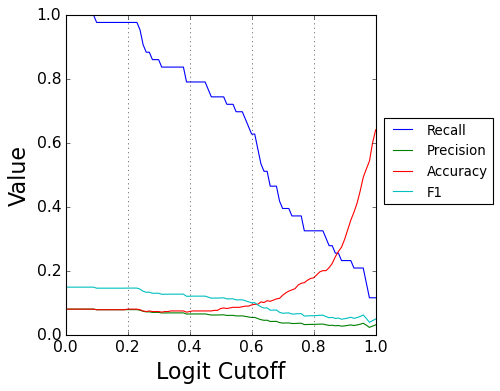

In [7]:
from classification_plots import logit, rpc, cm_by_row
Y_label = Y_test.replace({0:'N', 1:'Y'})
logit(Y_label.values, y_pred,'Y' )

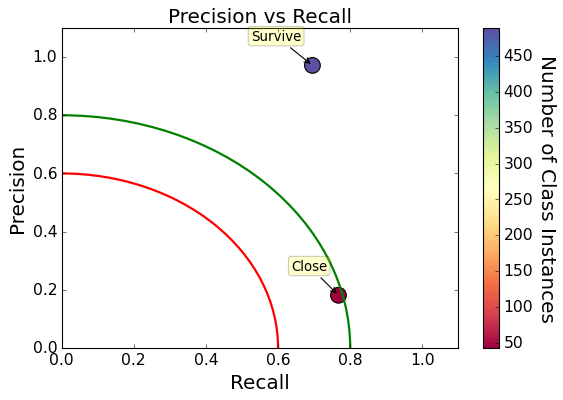

In [8]:
rpc(Y_test, 1*(y_pred>.9), labels = {0:'Close', 1:'Survive'})

In [9]:
feat_imp = list(zip(gbm.feature_name(),gbm.feature_importance()))
sorted(feat_imp, key = lambda x:-x[1])

[('LB_per_active_subject', 412),
 ('IP_variance', 373),
 ('MLB_per_active_subject', 344),
 ('AE_per_active_subject', 188),
 ('ULB_per_active_subject', 100),
 ('Active_Subject_Count', 86),
 ('SAE_per_active_subject', 56),
 ('RAE_per_active_subject', 49),
 ('Missed_Dose', 30),
 ('SRAE_per_active_subject', 3)]

In [ ]:
out.